In [1]:
%matplotlib inline

In [2]:
! pwd

/data/srlab1/TCAT/Analysis/PerDataset/UKCOVID


In [3]:
import scanpy  as sc
import muon as mu
import numpy as np
import matplotlib.pyplot as plt
from cnmf import Preprocess
import pandas as pd


sc.logging.print_versions()

/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.1.0
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cached_property     1.5.2
cffi                1.15.0
cloudpickle         2.2.1
cnmf                NA
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
dask                2022.02.0
dateutil            2.8.2
debugpy             1.6.0
decorator           5.1.1
defusedxml          0.7.1
entrypoints         0.4
fastcluster         1.2.6
fsspec              2023.1.0
h5py                3.6.0
harmonypy           NA
igraph              0.9.9
ipykernel           6.13.0
ipython_genutils    0.2.0
jedi                0.18.1
jinja2              3.1.1
joblib              1.1.0
jupyter_server      1.16.0
kiwisolver          1.4.2
leidenalg           0.8.9
llvmlite            0.38.0
markupsafe          2.1.1
matplotlib          3.5.1
matplotlib_inline   NA
mpl_toolkits        NA
mudata              0.2.1
muon                0.1.3


# Parameters

In [5]:
! ls ../../../Data/PerDataset/UKCOVID/haniffa21.RNAandADT.raw.ADTfixed.h5ad

../../../Data/PerDataset/UKCOVID/haniffa21.RNAandADT.raw.ADTfixed.h5ad


In [4]:
params = {
'harmony_vars' : ['Site', 'sample_id'],
'filter_mito_thresh' : None,
'RNA_normalize_targetsum' : 1e4,
'n_top_rna_genes' : 2000,
'n_top_adt_genes' : 75,
'feature_type_col' : 'feature_types', # Set to None if only RNA is included
'adt_feature_name' : 'Antibody Capture', # all other genes assumed to be RNA
'min_cells_per_RNA_gene' : 10,
'min_rna_counts_per_cell' : 500,
'filter_mito_genes' : False,
'filter_dot_genes' : True,
'max_scaled_thresh' : None,
'quantile_thresh' : .9999,
'n_neighbors' : 30,
'n_rna_pcs' : 36,
'n_adt_pcs' : 32,
'name_addition' : 'ADT_70', # Set to a string if you want to append that to the name of saved files to run multiple versions of script
'random_seed' : 14,
'celltype_subset_col' : 'full_clustering_reduced', # Set to None to do no filtering on cell type
'celltypes_to_include' : ['CD8', 'CD4', 'MAIT', 'gdT', 'Treg']

}



if params['name_addition'] is None:
    toadd = ''
else:
    toadd = params['name_addition']


original =  '../../../Data/PerDataset/UKCOVID/haniffa21.RNAandADT.raw.ADTfixed.h5ad'

paths = {
        'Original' : original, # AnnData containing RNA +/- ADT,
        'RNA_Varnorm_Harmony':original.replace('.h5ad', toadd + 'RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad'),
        'RNA_HVG_List':original.replace('.h5ad', toadd + 'RNA.HVGlist.tsv'),
        'Metadata' : original.replace('.h5ad', toadd + 'metadata.tsv'),
        'Raw_Filt_For_cNMF' : original.replace('.h5ad', toadd + 'FiltForcNMF.h5ad'),
        }
        
if params['feature_type_col'] is None:
    ## Output RNA only TP10K file if no ADT
    paths['TP10K'] = original.replace('.h5ad', toadd + 'RNA.TP10K.h5ad')
else:
    ## Output both RNA and ADT files
    paths['ADT_MI_Rank'] = original.replace('.h5ad', toadd + 'ADT.TP10K.VarNorm.leidenRNA_MI.tsv')
    paths['ADT_Varnom_Harmony'] = original.replace('.h5ad', toadd + 'ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad')
    paths['RNA_and_ADT_TP10K'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.TP10K.h5ad')
    paths['RNA_and_ADT_HVG_List'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.HVGlist.tsv')
    paths['RNA_and_ADT_Varnorm_Harmony_WNN'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5mu')
    paths['RNA_and_ADT_Varnorm_Harmony'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad')
    paths['WNN_UMAP'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.TP10K.VarNorm.HVG.HarmonyGeneCorrect.WNN.UMAP.tsv')
    
paths


{'Original': '../../../Data/PerDataset/UKCOVID/haniffa21.RNAandADT.raw.ADTfixed.h5ad',
 'RNA_Varnorm_Harmony': '../../../Data/PerDataset/UKCOVID/haniffa21.RNAandADT.raw.ADTfixedADT_70RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_HVG_List': '../../../Data/PerDataset/UKCOVID/haniffa21.RNAandADT.raw.ADTfixedADT_70RNA.HVGlist.tsv',
 'Metadata': '../../../Data/PerDataset/UKCOVID/haniffa21.RNAandADT.raw.ADTfixedADT_70metadata.tsv',
 'Raw_Filt_For_cNMF': '../../../Data/PerDataset/UKCOVID/haniffa21.RNAandADT.raw.ADTfixedADT_70FiltForcNMF.h5ad',
 'ADT_MI_Rank': '../../../Data/PerDataset/UKCOVID/haniffa21.RNAandADT.raw.ADTfixedADT_70ADT.TP10K.VarNorm.leidenRNA_MI.tsv',
 'ADT_Varnom_Harmony': '../../../Data/PerDataset/UKCOVID/haniffa21.RNAandADT.raw.ADTfixedADT_70ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_and_ADT_TP10K': '../../../Data/PerDataset/UKCOVID/haniffa21.RNAandADT.raw.ADTfixedADT_70RNA_and_ADT.TP10K.h5ad',
 'RNA_and_ADT_HVG_List': '../../../Data/PerDataset/UKCOVID/haniffa21.RNAan

# Run pipeline

In [6]:
adata = sc.read(paths['Original'])

Only considering the two last: ['.ADTfixed', '.h5ad'].
Only considering the two last: ['.ADTfixed', '.h5ad'].


In [15]:
if params['celltype_subset_col'] is not None:
    display(adata.obs[params['celltype_subset_col']].value_counts())
    adata = adata[adata.obs[params['celltype_subset_col']].isin(params['celltypes_to_include']), :]

CD4            144785
mono           133395
NK             104025
CD8            103238
B               61519
gdT             14716
MAIT            10777
Platelets        7366
Plasma           7154
DC               6970
pDC              4484
NKT              4418
Plasmablast      3912
HSC              3243
RBC              2135
ILC               845
Name: full_clustering_reduced, dtype: int64

/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


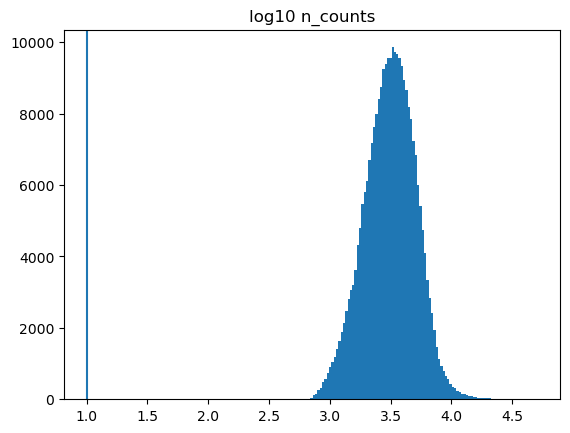

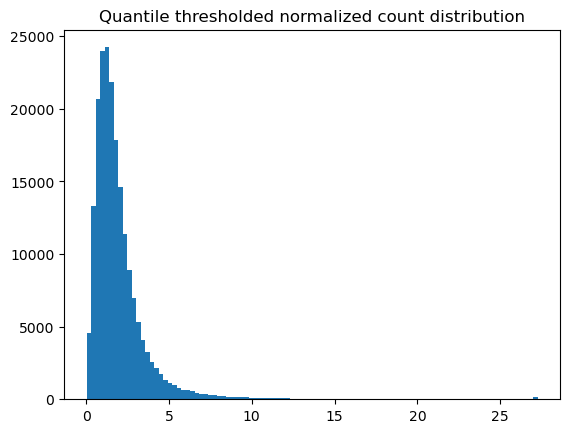

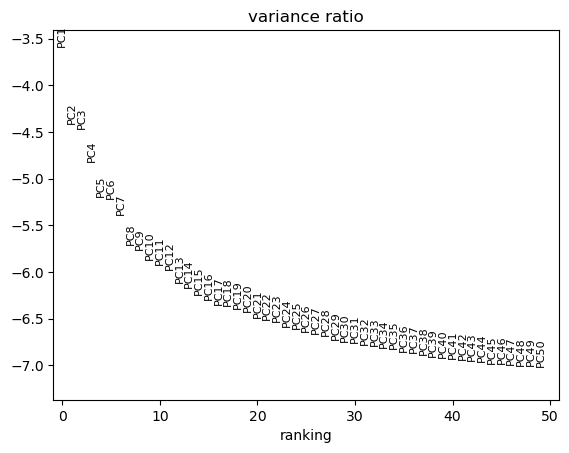

2023-08-03 22:30:18,597 - harmonypy - INFO - Iteration 1 of 20
2023-08-03 22:34:23,653 - harmonypy - INFO - Iteration 2 of 20
2023-08-03 22:38:53,306 - harmonypy - INFO - Iteration 3 of 20
2023-08-03 22:43:23,131 - harmonypy - INFO - Converged after 3 iterations
/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


In [18]:

if params['feature_type_col'] is not None:
    adata_RNA = adata[:, adata.var[params['feature_type_col']]!=params['adt_feature_name']]
    adata_ADT = adata[:, adata.var[params['feature_type_col']]==params['adt_feature_name']]
    
    adata_ADT.var_names_make_unique()
    adata_ADT.var['features_renamed'] = adata_ADT.var.index
    
else:
    adata_RNA = adata
    
adata_RNA.var_names_make_unique()
adata_RNA.var['features_renamed'] = adata_RNA.var.index

p = Preprocess(params['random_seed'])


adata_RNA = p.filter_adata(adata_RNA, filter_mito_thresh=params['filter_mito_thresh'], min_cells_per_gene = params['min_cells_per_RNA_gene'],
             min_counts_per_cell = params['min_rna_counts_per_cell'], filter_mito_genes = params['filter_mito_genes'],
             filter_dot_genes = params['filter_dot_genes'], makeplots=True)
adata_ADT = adata_ADT[adata_RNA.obs.index, :]

(adata_RNA_c, adata_tp10k, hvgs) = p.preprocess_for_cnmf([adata_RNA, adata_ADT], harmony_vars=params['harmony_vars'], n_top_rna_genes = params['n_top_rna_genes'],
                            librarysize_targetsum= 1e4, max_scaled_thresh = params['max_scaled_thresh'], quantile_thresh = params['quantile_thresh'], makeplots=True)

In [19]:
sc.write(paths['RNA_Varnorm_Harmony'], adata_RNA_c)
sc.write(paths['RNA_and_ADT_TP10K'], adata_tp10k)

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.TP10K', '.h5ad'].
Only considering the two last: ['.TP10K', '.h5ad'].


In [20]:
with open(paths['RNA_HVG_List'], 'w') as F:
    F.write('\n'.join(hvgs))

/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


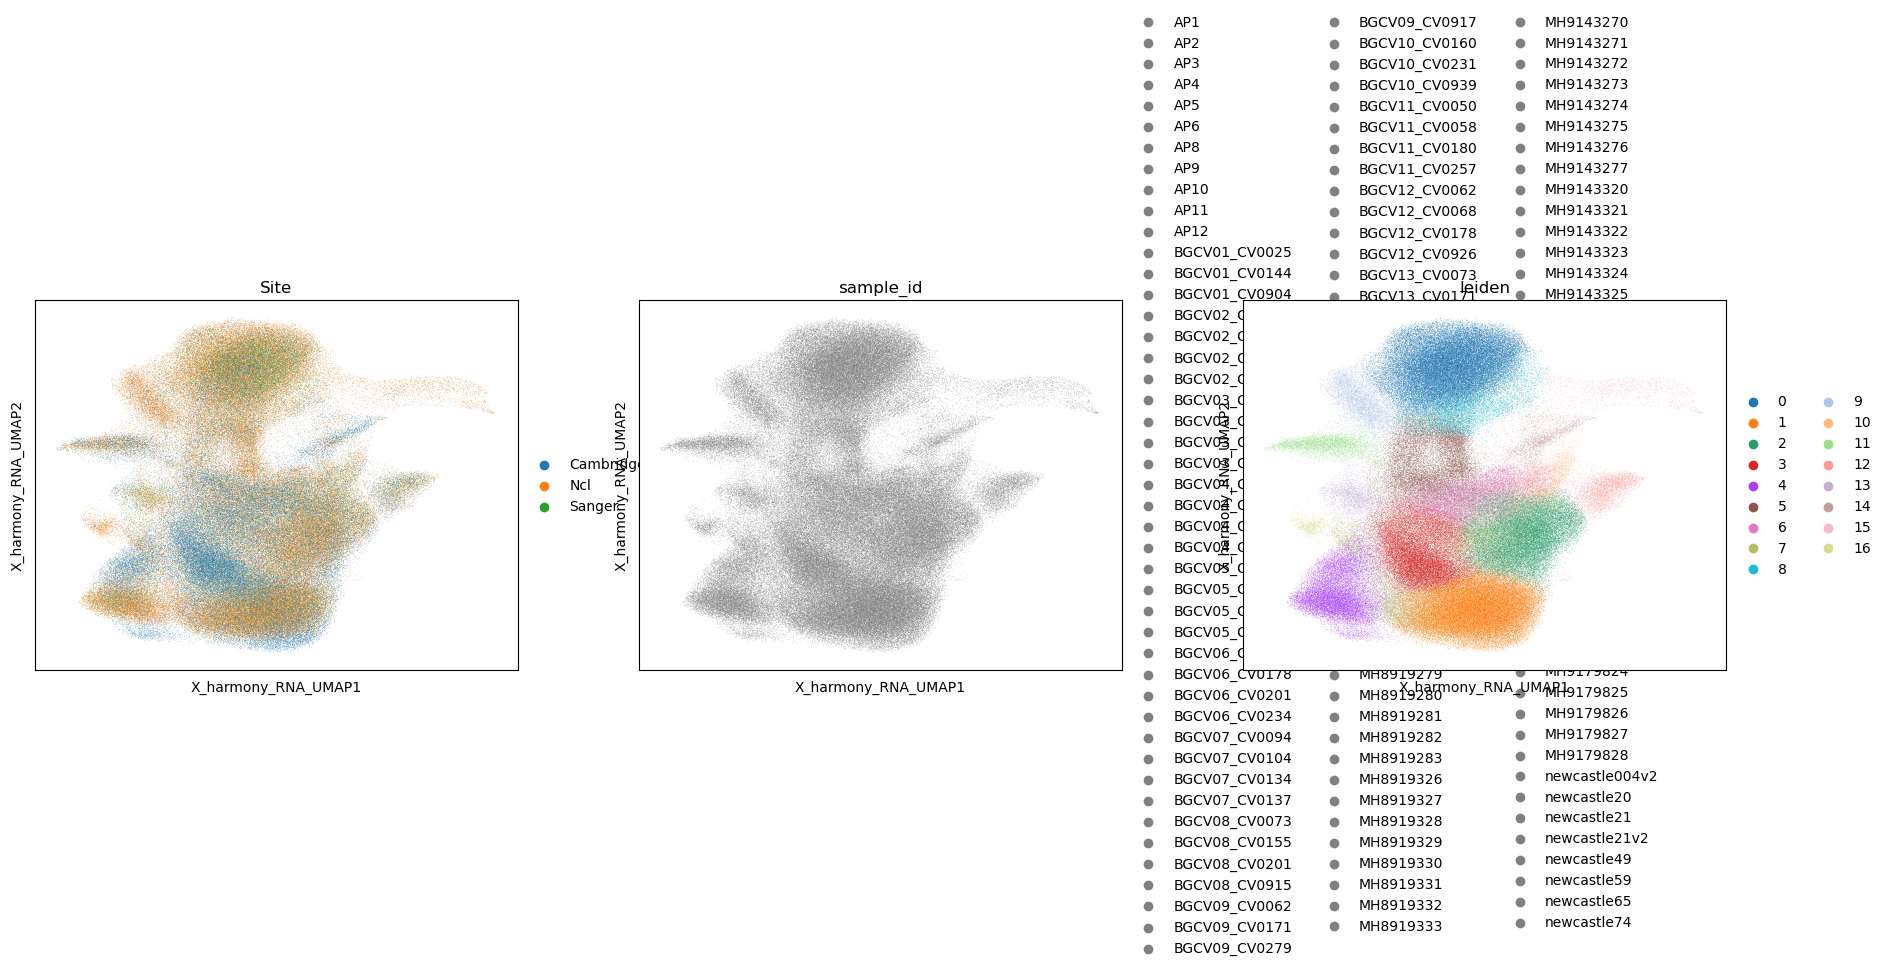

In [21]:
sc.pp.neighbors(adata_RNA_c, n_neighbors=params['n_neighbors'], n_pcs=params['n_rna_pcs'], use_rep='X_pca_harmony')
sc.tl.umap(adata_RNA_c)
adata_RNA_c.obsm['X_harmony_RNA_UMAP'] = adata_RNA_c.obsm['X_umap']
sc.tl.leiden(adata_RNA_c, resolution=1)
sc.pl.embedding(adata_RNA_c, basis='X_harmony_RNA_UMAP', color= params['harmony_vars'] + ['leiden'])

In [22]:
adata_RNA_c.obs.to_csv(paths['Metadata'], sep='\t')

In [7]:
# Filt raw data to cells used for cnmf only 
adata_RNA_c = sc.read(paths['RNA_Varnorm_Harmony'])
adata_filt = adata[adata_RNA_c.obs.index, ]

In [22]:
adata.shape, adata_RNA_c.shape, adata_filt.shape

((612982, 24929), (273516, 2000), (273516, 24929))

In [5]:
paths['Raw_Filt_For_cNMF']

'../../../Data/PerDataset/UKCOVID/haniffa21.RNAandADT.raw.ADTfixedADT_70FiltForcNMF.h5ad'

In [21]:
sc.write(paths['Raw_Filt_For_cNMF'], adata_filt)

Only considering the two last: ['.ADTfixedADT_70FiltForcNMF', '.h5ad'].
Only considering the two last: ['.ADTfixedADT_70FiltForcNMF', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


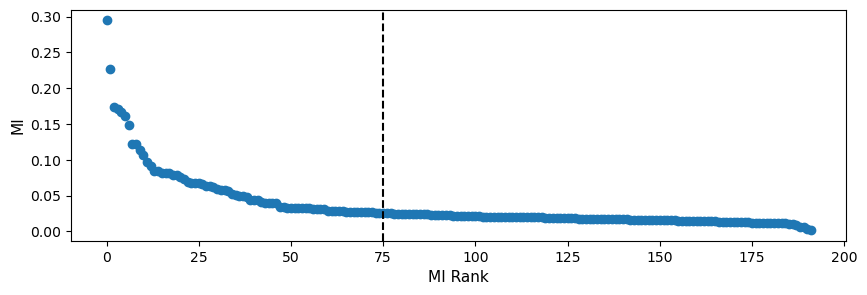

In [23]:
adata_ADT = p.select_features_MI(adata_ADT, adata_RNA_c.obs['leiden'], n_top_features = params['n_top_adt_genes'], max_scaled_thresh = params['max_scaled_thresh'], quantile_thresh = params['quantile_thresh'], makeplots=True)

In [24]:
adata_ADT.var.to_csv(paths['ADT_MI_Rank'], sep='\t')

/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


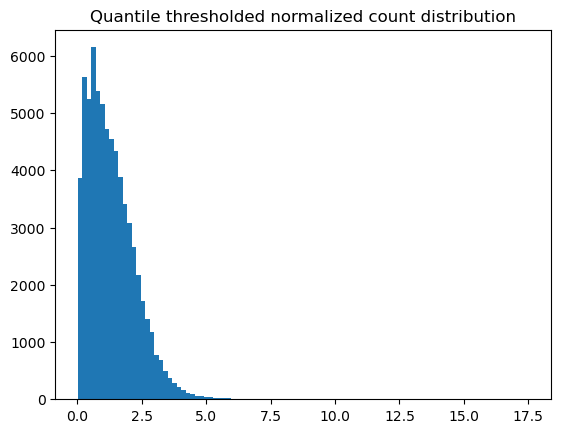

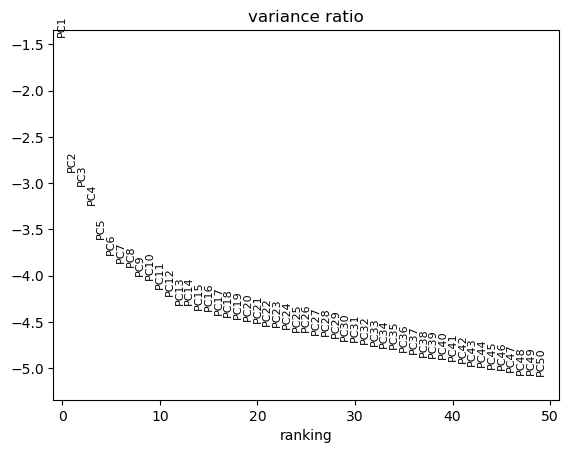

2023-08-03 23:26:51,867 - harmonypy - INFO - Iteration 1 of 20
2023-08-03 23:31:13,704 - harmonypy - INFO - Iteration 2 of 20
2023-08-03 23:35:38,694 - harmonypy - INFO - Converged after 2 iterations


In [25]:
adata_ADT_c, adata_ADT_hvgs = p.normalize_batchcorrect(adata_ADT, normalize_librarysize=False, harmony_vars=params['harmony_vars'], n_top_genes = None, max_scaled_thresh = params['max_scaled_thresh'],
                               quantile_thresh = params['quantile_thresh'], makeplots=True)

In [26]:
sc.pp.neighbors(adata_ADT_c, n_neighbors=params['n_neighbors'], n_pcs=params['n_adt_pcs'], use_rep='X_pca_harmony')

In [27]:
adata_ADT_c

AnnData object with n_obs × n_vars = 273516 × 75
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'pct_mito', 'IEG_GEP_Score', 'n_counts', 'FOS_expr', 'JUN_expr', 'JUNB_expr', 'ZFP36_expr', 'IEG_Usage', 'RNA_Modality_Weight', 'leiden_WNN', 'full_clustering_reduced', 'leiden_WNN_lab', 'leiden_WNN_lab_reduced'
    var: 'feature_types', 'ADT_MI', 'ADT_MI_Rank', 'IEG_Filter', 'IEG_GEP_Score', 'Name', 'Name_ADT_Fixed', 'Gene_ADT_Fixed', 'Clone_ADT_Fixed', 'features_renamed', 'mean', 'std', 'MI', 'MI_Rank', 'MI_diff', 'highly_variable'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_pca_harmony'
    obsp: 'distances', 'connectivities'

/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


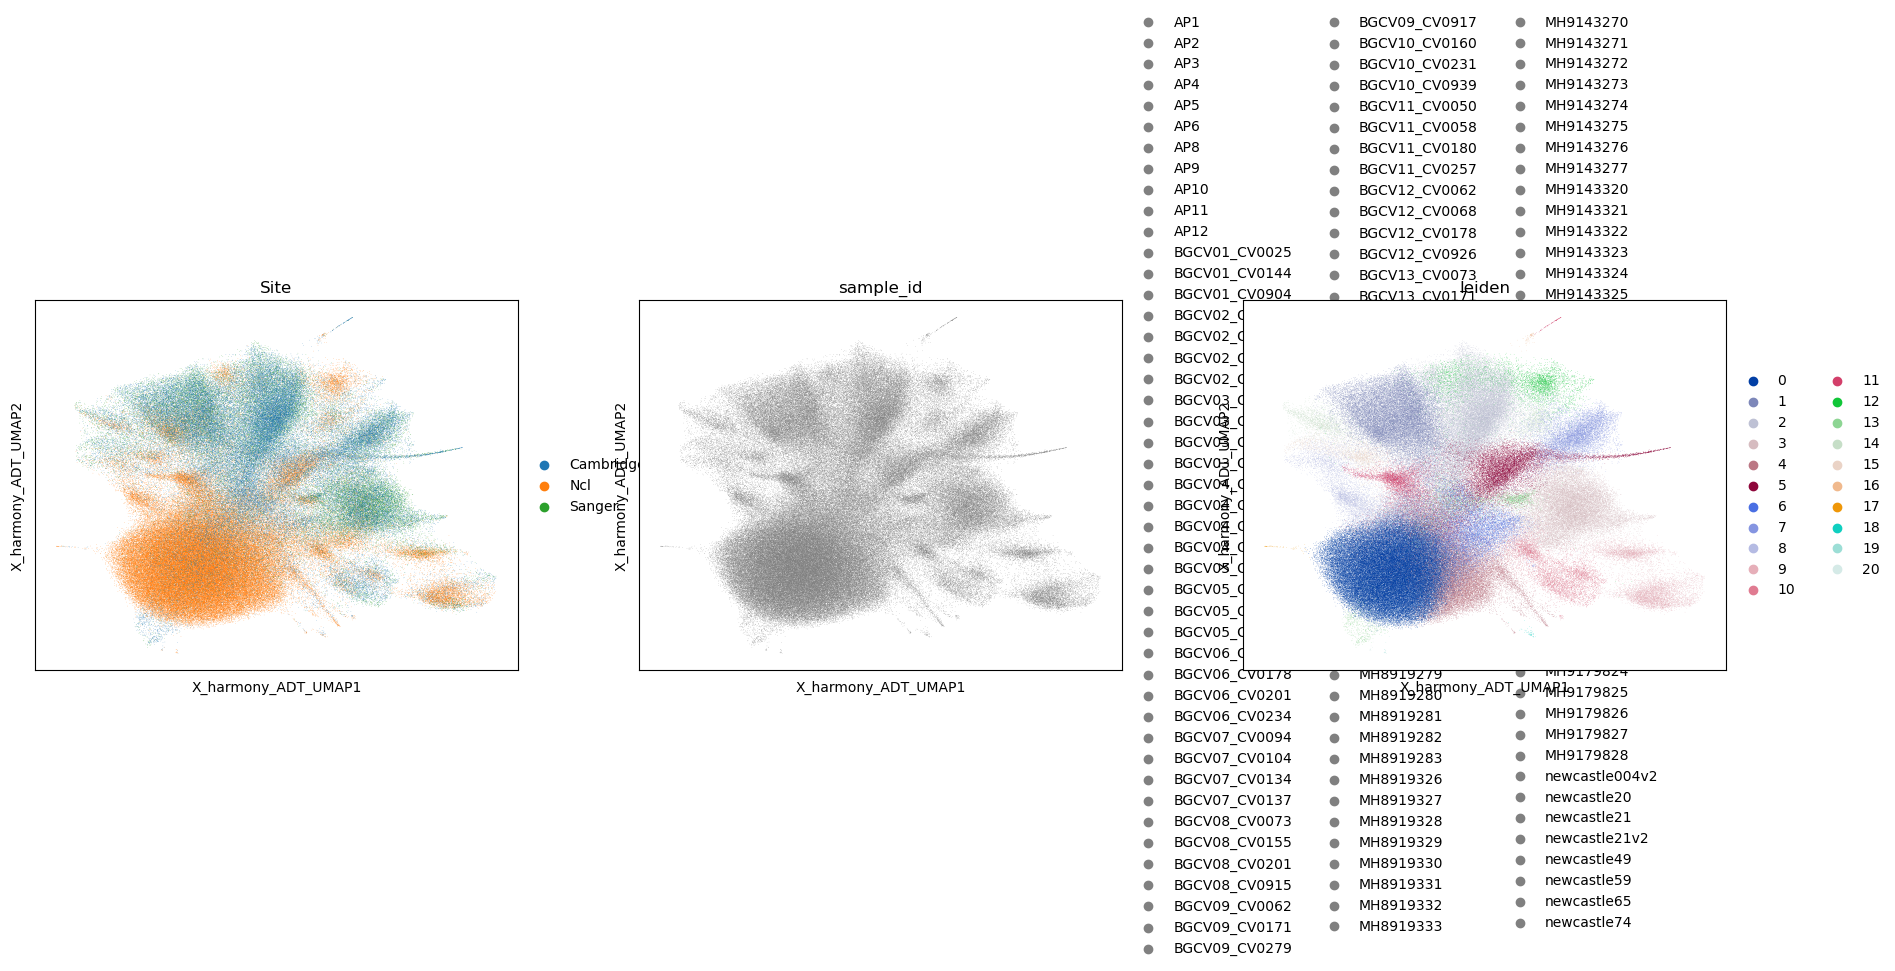

In [28]:
sc.tl.umap(adata_ADT_c)
adata_ADT_c.obsm['X_harmony_ADT_UMAP'] = adata_ADT_c.obsm['X_umap']
sc.tl.leiden(adata_ADT_c, resolution=1)
sc.pl.embedding(adata_ADT_c, basis='X_harmony_ADT_UMAP', color= params['harmony_vars'] + ['leiden'])

In [29]:
sc.write(paths['ADT_Varnom_Harmony'], adata_ADT_c)

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/pynndescent/pynndescent_.py:339: NumbaWarning: Cannot cache compiled function "init_rp_tree" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_rp_tree(data, dist, current_graph, leaf_array)
/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/pynndescent/pynndescent_.py:341: NumbaWarning: Cannot cache compiled function "init_random" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_random(n_neighbors, data, current_graph, dist, rng_state)
/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/pynndescent/pynndescent_.py:351: NumbaWarning: Cannot cache compiled function "process_candidates" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  nn_descent_internal_low_memory_parallel(
/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/pynndescent/pynndescent_.py:339: NumbaWarning: Cann

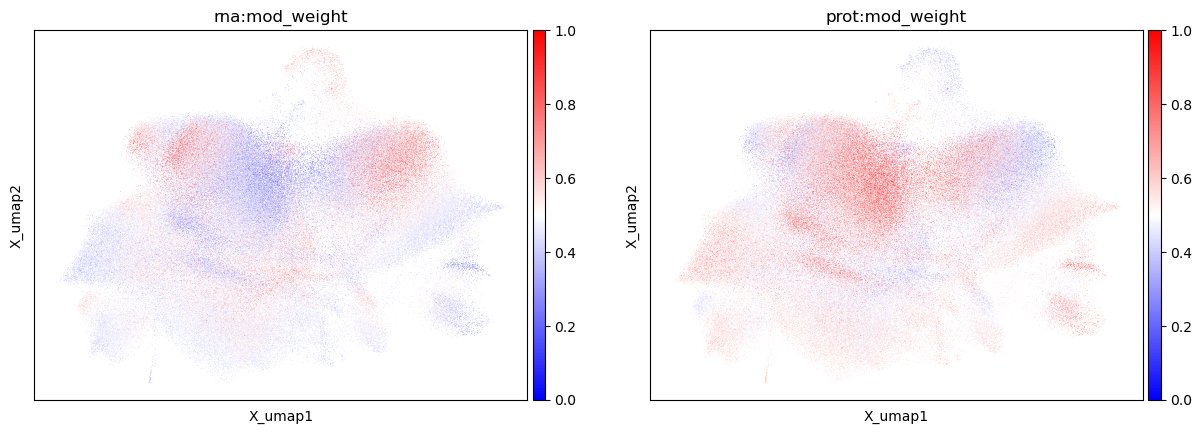

/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


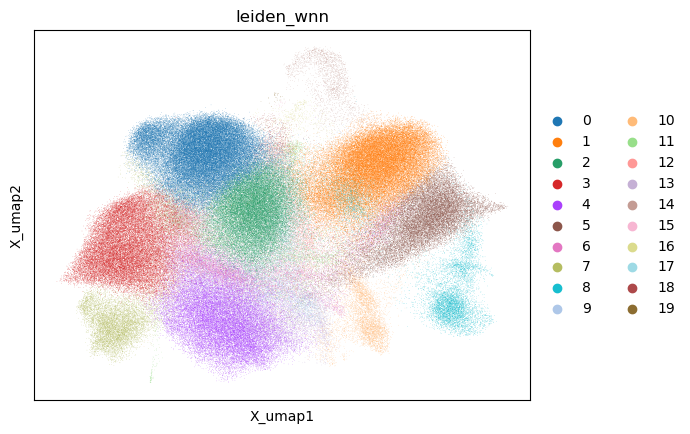

In [30]:
mdata = mu.MuData({'rna': adata_RNA_c, 'prot': adata_ADT_c})
mu.pp.neighbors(mdata, key_added='wnn')
mu.tl.umap(mdata, neighbors_key='wnn', random_state=10)
mdata.obsm["X_wnn_umap"] = mdata.obsm["X_umap"]
mu.pl.umap(mdata, color=['rna:mod_weight', 'prot:mod_weight'], cmap='bwr')
sc.tl.leiden(mdata, resolution=1.0, neighbors_key='wnn', key_added='leiden_wnn')
mu.pl.umap(mdata, color=['leiden_wnn'])

In [31]:
mdata['rna'].obs['leiden_wnn'] = mdata.obs['leiden_wnn']
mdata['prot'].obs['leiden_wnn'] = mdata.obs['leiden_wnn']

In [32]:
sc.tl.rank_genes_groups(mdata['rna'], groupby='leiden_wnn')

In [33]:
sc.tl.rank_genes_groups(mdata['prot'], groupby='leiden_wnn')

In [34]:
pd.DataFrame(mdata['rna'].uns['rank_genes_groups']['names']).head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,CCR7,RPS3A,LEF1,RPL39,RPL29,RPS8,RPL34,TCF7,RPS10,RPS21,SELL,MAL,ACTN1,RPL37,NOSIP,ADTRP,EEF1A1,TMIGD2,EEF1G,AIF1
1,CCL5,NKG7,CST7,GZMH,GZMA,CTSW,PLEK,KLRD1,PRF1,FGFBP2,CD8A,GNLY,GZMM,TBX21,HLA-DPB1,GZMB,SH3BGRL3,ADGRG1,HLA-DPA1,ZEB2
2,IL7R,LTB,VIM,TRADD,PLP2,AQP3,ITGB1,S100A11,CD82,ANXA1,TIMP1,TNFRSF4,COTL1,CAPG,GATA3,S100A4,TTC39C,ADAM19,S100A10,CD69
3,CCR7,RPS3A,LEF1,EEF1G,TCF7,RPS8,FHIT,MAL,RPL34,RPL29,RPL39,ADTRP,TSHZ2,SELL,IL6ST,NOSIP,EEF1A1,TMIGD2,RPS21,CHRM3-AS2
4,IL7R,VIM,LTB,TRADD,PLP2,ANXA1,ITGB1,KLF6,CD82,S100A11,TPT1,CD69,AQP3,S100A4,FOS,ZFP36L2,TIMP1,RPL39,EEF1A1,JUNB
5,NKG7,CCL5,CST7,GZMH,GZMA,CTSW,GNLY,CD8A,PRF1,KLRD1,PLEK,GZMB,FGFBP2,GZMM,HLA-DPB1,SH3BGRL3,HLA-DPA1,HLA-B,SRGN,ZEB2
6,PPBP,NRGN,SPARC,CAVIN2,PF4,TUBB1,GNG11,CLU,MYL9,MPIG6B,F13A1,TREML1,MAP3K7CL,PTGS1,PRKAR2B,RGS18,ITGA2B,GP9,PF4V1,CMTM5
7,CD8B,LINC02446,RPS3A,NELL2,RPS8,RPL34,EEF1A1,RPS21,RPLP0,CCR7,RPL29,LEF1,AIF1,RPL39,ACTN1,RPL37,EEF1G,HSP90AB1,CD7,CD8A
8,CCL5,NKG7,CST7,TRDV2,TRGV9,KLRD1,CTSW,GZMA,KLRG1,GNLY,HOPX,KLRC1,PRF1,TRDC,GZMM,KLRB1,MATK,PLEK,SRGN,LYAR
9,FOXP3,RTKN2,STAM,CTLA4,IL10RA,TIGIT,ARID5B,RGS1,IL32,CORO1B,CD27,SHMT2,IL2RA,IKZF2,PBXIP1,PELI1,SAT1,NCF4,CYTOR,DUSP4


In [35]:
pd.DataFrame(mdata['prot'].uns['rank_genes_groups']['names']).head(10).T

,0,1,2,3,4,5,6,7,8,9
0,AB_CD158f,AB_CD169,AB_CD223,AB_CCR7,AB_CD324,AB_CD303,AB_CD307d,AB_TCR-V-24-J-18,AB_CD122,AB_c_Met
1,AB_CD158f,AB_TIGIT,AB_CD169,AB_CD223,AB_CD122,AB_CD307d,AB_CD303,AB_TCR-V-24-J-18,AB_CD324,AB_CX3CR1
2,AB_CD158f,AB_CD169,AB_CD223,AB_CD307d,AB_CD324,AB_mouseCD49f,AB_CD303,AB_CD122,AB_TCR-V-24-J-18,AB_c_Met
3,AB_CD4-2,AB_CD3-1,AB_abTCR,AB_CD5,AB_CD7,AB_CD27-1,AB_CD47,AB_CD52,AB_CD62L,AB_CD28
4,AB_CD4-2,AB_CD28,AB_CD45RO,AB_CD99,AB_CD2,AB_CD95,AB_mouseCD49f,AB_CD5,AB_CD82,AB_CD127
5,AB_CD11a,AB_CD244,AB_CD8,AB_CD49d,AB_CD2,AB_CD99,AB_CD18,AB_KLRG1_MAFA,AB_CD54,AB_CD314
6,AB_CD41,AB_CD62P,AB_mouseCD49f,AB_CD29,AB_CD226-2,AB_CD47,AB_CD58,AB_CD224,AB_CD194,AB_CD195
7,AB_CD8,AB_CD45RA,AB_CD73,AB_CD305,AB_CD314,AB_CD7,AB_CD27-1,AB_CD127,AB_CD5,AB_CD2
8,AB_TCR-Vd2,AB_CD94,AB_TCR-V-9,AB_CD244,AB_CD3-1,AB_KLRG1_MAFA,AB_CD11a,AB_CD314,AB_CD18,AB_CD54
9,AB_CD95,AB_CD4-2,AB_CD39,AB_CD45RO,AB_CD25,AB_CD28,AB_CD278,AB_CD194,AB_CD5,AB_CD27-1


In [36]:
mu.write(paths['RNA_and_ADT_Varnorm_Harmony_WNN'], mdata)

/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [37]:
paths['WNN_UMAP']

'../../../Data/PerDataset/UKCOVID/haniffa21.RNAandADT.raw.ADTfixedADT_70RNA_and_ADT.TP10K.VarNorm.HVG.HarmonyGeneCorrect.WNN.UMAP.tsv'

In [38]:
umap = pd.DataFrame(mdata.obsm['X_wnn_umap'], index=mdata.obs.index, columns=['WNN_UMAP_1', 'WNN_UMAP_2'])

In [39]:
umap.to_csv(paths['WNN_UMAP'], sep='\t')

In [40]:
merge_var = pd.concat([adata_RNA_c.var, adata_ADT_c.var], axis=0)            
adata_c = sc.AnnData(np.concatenate((adata_RNA_c.X, adata_ADT_c.X), axis=1), obs=adata_RNA_c.obs, var=merge_var)

In [41]:
adata_c.obsm['X_pca_rna'] = adata_RNA_c.obsm['X_pca']
adata_c.obsm['X_pca_rna_harmony'] = adata_RNA_c.obsm['X_pca_harmony']
adata_c.obsm['X_umap_rna'] = adata_RNA_c.obsm['X_harmony_RNA_UMAP']

adata_c.obsm['X_pca_adt'] = adata_ADT_c.obsm['X_pca']
adata_c.obsm['X_pca_adt_harmony'] = adata_ADT_c.obsm['X_pca_harmony']
adata_c.obsm['X_umap_adt'] = adata_ADT_c.obsm['X_harmony_ADT_UMAP']
adata_c.obsm['X_umap_WNN'] = mdata.obsm['X_wnn_umap']

In [42]:
sc.write(paths['RNA_and_ADT_Varnorm_Harmony'], adata_c)

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
